In [1]:
import os
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
print(BASE_DIR)

import numpy as np
import pandas as pd

import bokeh.plotting as bp
from bokeh.models import tools as bmt

from bokeh.io import output_notebook, export_png
output_notebook()

from IPython.display import Image

/Users/biplovbhandari/UAH/Fall_2021/ESS_690_Hydrology/ess-690-hydrology


Loading BokehJS ...

#### Q 1. A)

The water balance equation for the given watershed is

P + $GW_{in}$ + I - (Q + ET + $GW_{out}$) = $\Delta$S
<br>
where
<br>
P          = Precipitation
<br>
$GW_{in}$  = Groundwater inflow
<br>
Q          = Runoff
<br>
I          = Infiltration
<br>
ET         = Evapotration
<br>
$GW_{out}$ = Groundwater outflow
<br>
$\Delta$S  = Change in storage

#### Q 1. B)

In [2]:
P = 22 # in/yr
ET = 12 # in/yr
Q = 11 # in/yr
GW_out = 1 # in/yr
GW_in = 1 # in/yr
I = 3 # in/yr
A = 100000 * 144 # inches2

In [3]:
ΔS = P + GW_in + I  - (Q + ET + GW_out)

In [4]:
ΔS # in/yr

2

In [5]:
Volume = ΔS * A # in3/yr

In [6]:
Volume # in3/yr

28800000

#### Q 2.

In [7]:
# experiment 1
# looking at the seasonal cycle and interpreting the middle values.
# runoff for 12 months (in order)
# Q_all = [80, 80, 80, 120, 160, 200, 166.67, 133.34, 100, 93.33, 86.67, 80]
# this gives negative values;

#so just using the value as it is and average them to get the yearly average value
Q_all = [80, 80, 200, 100, 80]
Q_all = np.array(Q_all)
Q_avg = np.mean(Q_all)
Q_avg = int(Q_avg) * 1.
Q_avg # cfs (cubic feet per sec)

108.0

In [8]:
# watershed area
A = 100. # mi2
A = A * 2.788e7 # feet2

In [9]:
Q_avg = Q_avg / A # feet per sec

In [10]:
Q_avg

3.873744619799139e-08

In [11]:
Q_avg = Q_avg * (60 * 60 * 24 * 365) # feet
Q_avg = round(Q_avg, 3)

In [12]:
Q_avg # feet

1.222

In [13]:
Q_avg = Q_avg * 12. # inches
Q_avg = round(Q_avg, 3)

In [14]:
Q_avg

14.664

In [15]:
# precipitation (inches)
# quarterly average
P_all = [20., 15., 15., 10.]
P_all = np.array(P_all)
P_avg = np.mean(P_all)
P_avg # inches (yearly avg)

15.0

In [16]:
ET = P_avg - Q_avg

In [17]:
ET # inches

0.3360000000000003

In [18]:
runoff_ratio = Q_avg / P_avg

In [19]:
runoff_ratio

0.9776

#### Q 3.

In [20]:
ϕ = 0.3 # porosity
Kh = 1e-5 # 1 * 10**(-5) # m/s Hydraulic conductivity
θ = 0 # angle
h1 = 12 # m
h2 = 10 # m
L = 100 # m
A = 50 # m2

In [21]:
# specific discharge
qx = -Kh * (h2 - h1) / L

In [22]:
qx # m/s

2.0000000000000002e-07

In [23]:
# Discharge
Q = qx * A

In [24]:
Q # m3/s

1e-05

In [25]:
# Average velocity
Ux = qx / ϕ

In [26]:
Ux # m/s

6.666666666666667e-07

#### Q 4.

In [27]:
Ks = Kns = 3.67e-4 # cm/s
θs = 0.523 # water content
ψ_abs = 31.4 # absolute pressure head
θi = 0.3
delta_θ = θs - θi

i1 = 6 * Ks # cm/s (for 10 minutes)
i2 = 3 * Ks # cm/s (after 10 minutes)
Ks

0.000367

In [28]:
# for first ten minutes
F1_tp = (delta_θ * ψ_abs) / (1. + (i1 / Ks)) # cm total mass at ponding
tp1 = F1_tp / i1 # sec
dt1 = 10. * 60 - tp1

In [29]:
print(f'Mass at ponding is: {round(F1_tp, 3)} cm')
print(f'Time at ponding is {round(tp1, 3)} sec')

Mass at ponding is: 1.0 cm
Time at ponding is 454.275 sec


In [30]:
# rewriting green and ampt model eqn in simpler form
# 𝐹_𝑡𝑝+𝐾∆𝑡+∆𝜃𝜓 ∗ ln⁡((𝐹_(𝑡𝑝+∆𝑡)+∆𝜃𝜓)/(𝐹_𝑡𝑝+∆𝜃𝜓 ))
# m + ∆𝜃𝜓 * ln(c)

# first ten minutes
df1 = pd.DataFrame(index = np.arange(0, 1.4, .01), columns = ['m', 'c', 'GA', 'delta', 'f_t', 't'])
df1.index.name = 'F_tp_dt'

df1['m'] = F1_tp + (Ks * dt1)
df1['c'] = (df1.index + (delta_θ * ψ_abs)) / (F1_tp + (delta_θ * ψ_abs))

df1['GA'] = df1.m + delta_θ * ψ_abs * np.log(df1.c)
df1['delta'] = df1.GA - df1.index

df1['f_t'] = Ks * (1. + ( (delta_θ * ψ_abs) / df1.index ))
df1['f_t'] = np.where(df1.index <= F1_tp, i1, df1['f_t'])


df1['t1'] = (df1.index - F1_tp) / Ks
df1['t2'] = ψ_abs * delta_θ / Ks
df1['t3'] = (df1.index + (ψ_abs * delta_θ)) / (F1_tp + (ψ_abs * delta_θ))
df1['t'] = df1['t1'] - df1['t2'] * np.log(df1['t3']) + tp1
df1 = df1.drop(columns=['t1', 't2', 't3'], axis=1)


In [31]:
df1

,m,c,GA,delta,f_t,t
F_tp_dt,,,,,,
0.00,1.053795,0.875000,0.118782,0.118782,0.002202,276.344085
0.01,1.053795,0.876250,0.128775,0.118775,0.002202,276.363524
0.02,1.053795,0.877499,0.138753,0.118753,0.002202,276.421764
0.03,1.053795,0.878749,0.148718,0.118718,0.002202,276.518697
0.04,1.053795,0.879998,0.158668,0.118668,0.002202,276.654212
...,...,...,...,...,...,...
1.35,1.053795,1.043697,1.353274,0.003274,0.002271,591.079769
1.36,1.053795,1.044947,1.361652,0.001652,0.002257,595.497631
1.37,1.053795,1.046196,1.370021,0.000021,0.002243,599.942779


the total infiltration for the first 10 mins (i.e. 600 sec) will be (from above df) ~ 1.37 cm.


In [32]:
# after ten minutes
# considering the 1 hour design

F2_tp = (delta_θ * ψ_abs) / (1. + (i2 / Ks)) # cm total mass at ponding
print(f'Mass at ponding is: {round(F2_tp, 3)} cm')
tp2 = F2_tp / i2 # sec
print(f'Time at ponding is {round(tp2, 3)} sec')
# for 60 mins design; the 10 mins are from above so the remaining is 50 mins for this intensity
dt2 = 50. * 60. - tp2 # in sec

df2 = pd.DataFrame(index = np.arange(0., 3.8, .1), columns = ['m', 'c', 'GA', 'delta', 'f_t', 't'])
df2.index.name = 'F_tp_dt'

df2['m'] = F2_tp + (Ks * dt2)
df2['c'] = (df2.index + (delta_θ * ψ_abs)) / (F2_tp + (delta_θ * ψ_abs))

df2['GA'] = df2.m + delta_θ * ψ_abs * np.log(df2.c)
df2['delta'] = df2.GA - df2.index

df2['f_t'] = Ks * (1. + ( (delta_θ * ψ_abs) / df2.index ))
df2['f_t'] = np.where(df2.index <= F2_tp, i2, df2['f_t'])

# use the formula in slide 16
df2['t1'] = (df2.index - F2_tp) / Ks
df2['t2'] = ψ_abs * delta_θ / Ks
df2['t3'] = (df2.index + (ψ_abs * delta_θ)) / (F2_tp + (ψ_abs * delta_θ))
df2['t'] = df2['t1'] - df2['t2'] * np.log(df2['t3']) + tp2
df2 = df2.drop(columns=['t1', 't2', 't3'], axis=1)


Mass at ponding is: 1.751 cm
Time at ponding is 1589.964 sec


In [33]:
df2

,m,c,GA,delta,f_t,t
F_tp_dt,,,,,,
0.0,2.268033,0.800000,0.705538,0.705538,0.001101,1077.554337
0.1,2.268033,0.811425,0.804830,0.704830,0.001101,1079.481680
0.2,2.268033,0.822850,0.902735,0.702735,0.001101,1085.191930
0.3,2.268033,0.834275,0.999289,0.699289,0.001101,1094.580758
0.4,2.268033,0.845700,1.094530,0.694530,0.001101,1107.548092
0.5,2.268033,0.857125,1.188493,0.688493,0.001101,1123.997889
0.6,2.268033,0.868550,1.281211,0.681211,0.001101,1143.837920
0.7,2.268033,0.879975,1.372718,0.672718,0.001101,1166.979574
0.8,2.268033,0.891400,1.463045,0.663045,0.001101,1193.337667


the total infiltration for the first 50 mins (i.e. 3000 sec) will be (from above df) ~ 3.6 cm.

So the total amount of water infiltrated during the 60 min rainfall event will be 1.37 + 3.6 = 4.97 cm

#### Q.5

Even though the porosity of the clay soil is higher than the sandy soil, the hydraulic conductivity is higher for the sandy soil because the size of the clay soil is small, as a result they can hold a large volume of water. This also means that the grains are highly packed in clay soil, and thus a small pore space exists between the grains. Thus it is harder for water to find the space to flow through a highly porous soil that are very closely packed.
<br>
The sand would have the highest hydraulic conductivity.
Even though the clay has the highest water content becuase of high porosity, it also has the highest wilting point. As a result, the water availability decreases and in fact, is equivalent to the sand which has low porosity and low wilting point. Thus, the water availabile is highest for silt loam soil.

This is also evident from the following figure.

![Soil Water Content & Available Water](https://i.imgur.com/FrJBts4.png)


#### Q. 6

Once the infiltration has begun, the physical minimum infiltration rate that a soil can reach is the Ks which is the hydraulic conductivity at the natural saturation, given that the rainfall intensity is greater than the hydraulic conductivity. This happens when the water content in the soil increases and reaches the saturation, and thus the pressure force decreases. As long as the rainfall continues, the infiltration will continue however decreasing exponentially and asymptotically reaching Ks.
<br>This is also illustrated by the following figure.

![Hypothetical curves of infiltration rate versus time](https://open.library.okstate.edu/app/uploads/sites/4/2019/03/Fig-6.4-1024x775.png)
<br>
Fig: Hypothetical curves of infiltration rate, i, versus time, t, during infiltration of rainfall reaching the soil surface at a constant rate. <br>
The solid curves labeled (1) through (4) represent different rainfall rates, with curve 1 being the greatest and curve 4 the least. <br>
Curve 4 represents a rainfall rate below the soil’s saturated hydraulic conductivity, Ks. The end of the horizontal segment of each <br>
curve indicates the time at which water first begins to pond on the surface, tp. Adapted from Mein and Larson (1971). <br>

#### Q. 7

For soil B, drawing and finding the percent of each soil class as follows:

![Soil Water Content & Available Water](https://i.imgur.com/lQkSO2h.jpeg)

This gives us the following:  <br>
Clay: ~ 0% <br>
Sand: ~ 80% <br>
Silt: ~ 20% <br>
<br>
From the USDA Soil texture triangle, this is a loamy sand soil.

#### Q 8.

The Pressure Head |ψ|(θ) and Volumertic water content (θ) relation is highly non-linear as can be seen from graph. Note that the Y-axis plots the absolute value. So a high absolute pressure head means more tension in the soil.
For soils, as the porosity increases, the pressure head also increases. For example, the clay has very high pressure head compared to the sand. At very high tension, the curve is nearly vertical and reflects the residual water content held in the soil against all forces. As the water content in the soil increases, the tension also decreases and becomes zero (0) when the water content equals the porosity (saturation). Also can be noticed that as the water content increases the difference in the tension for various soil also decreases.

#### Q 9.

In [34]:
n = 0.42 # porosity
θr = 0.02 # residual water content
Ks = 1.5 # cm/h saturated hydraulic conductivity
ψ_ae = 29 # cm; absolute air entry head
b = 7 # pore size distribution index

In [35]:
# PH: Pressure head
# index is the θ
df = pd.DataFrame(index = np.arange(0.01, 0.5, .01), columns=['θ*', 'PH'])
df['θ*'] = (df.index - θr) / (n - θr)
df['PH'] = np.where(df['θ*'] < 1, ψ_ae * (1 / df['θ*'])**b, ψ_ae)

In [36]:
def initialize_fig(title: str = 'your_title',
                   x_axis_label: str = 'x_axis_label',
                   x_axis_type: str = 'auto',
                   y_axis_label: str = 'y_axis_label',
                   y_axis_type: str = 'auto',
                   tools: str = 'pan,wheel_zoom,box_zoom,reset',
                   tooltips: list = [],
                   formatters: dict = {},
                   plot_height: int = 300,
                   fig_sizing_mode: str = 'scale_width',
                   ) -> bp.figure:
    # bokeh style
    TOOLS = tools
    hover_tool = bmt.HoverTool(tooltips=tooltips, formatters=formatters)

    fig = bp.figure(title=title,
                    x_axis_label=x_axis_label,
                    x_axis_type=x_axis_type,
                    y_axis_label=y_axis_label,
                    y_axis_type=y_axis_type,
                    plot_height=plot_height,
                    tools=TOOLS,
                   )
    fig.add_tools(hover_tool)
    fig.sizing_mode = fig_sizing_mode

    return fig

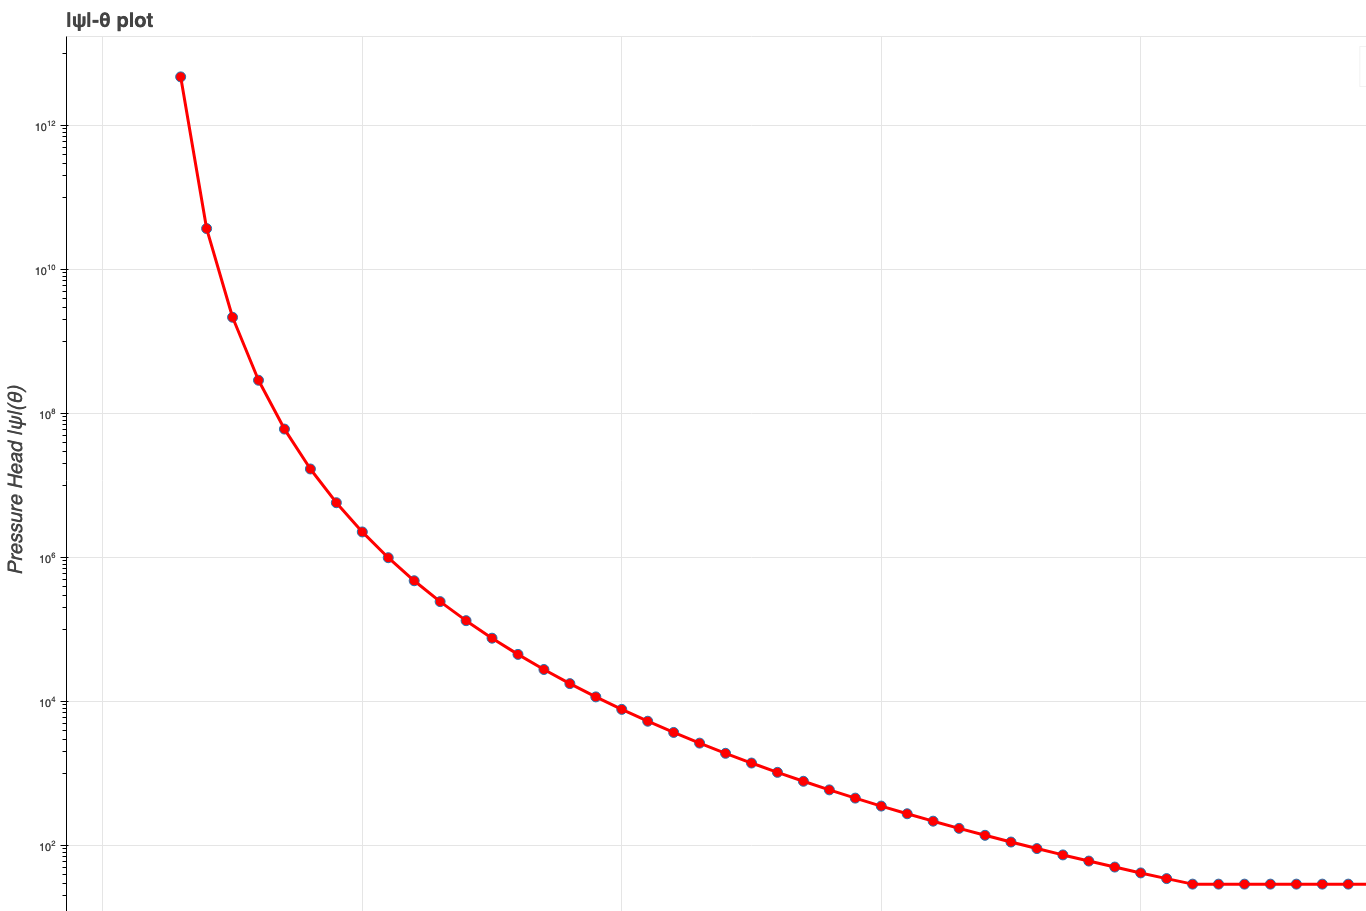

In [37]:
# |ψ| vs θ
fig = initialize_fig(title = '|ψ|-θ plot ',
                     x_axis_label = 'Volumertic water content (θ)',
                     y_axis_label = 'Pressure Head |ψ|(θ)',
                     y_axis_type = 'log',
                     tooltips = [
                         ('θ',      '$x'),
                         ('|ψ|(θ)', '$y'),
                     ],
                     plot_height = 300,
                    )

fig.title.text_font_size = '15pt'
fig.xaxis.axis_label_text_font_size = '15pt'
fig.yaxis.axis_label_text_font_size = '15pt'

fig.circle(df.index, df.PH, fill_color='red', size=10, legend_label=f'Soil')
fig.line(df.index, df.PH, line_width=3, line_color='red', legend_label=f'Soil')

fig.legend.location = 'top_right'
fig.legend.click_policy='hide'
bp.show(fig)

export_png(fig, filename=f'{BASE_DIR}/Test#1/problem_9_a.png', height=200, width=300)
Image(f'{BASE_DIR}/Test#1/problem_9_a.png')


#### bonus

#### b. the height of the top of the capillary fringe for the hydrostatic conditions is equal to the absolute value of the air-entry pressure head, i.e. ψ_ae which is 29 cm. Therefore, the position (height) of the top of the capillary fringe is 1.2 - 0.29 = 0.91 m from the surface.

In [38]:
# effective moisture content 

# for water table

θ_water_table = n # θ = water content
θ_effective_water_table = (θ_water_table - θr) / (n - θr)

In [39]:
θ_effective_water_table

1.0

In [40]:
# for top of capillary fringe
# the actual relationship has to do with the recchanrge rate R
# for the capillary fringes, the R << Kh, as a result the effect of R can be neglected and thus can be assumed as
θ_cf = n
θ_effective_cf = (θ_cf - θr) / (n - θr)

In [41]:
θ_effective_cf

1.0

In [42]:
# for the surface
# since this is a hydrostatic condition, assuming recharge rate R to be 0
R = 0
z0 = 1.2 # m; depth to the water table
z = 0. # depth at surface

# using relation 8.12b from p353
θ_surface = n * (0 + (1. - 0) * ( (z0 - z) / (ψ_ae * (1. + 0)) )**((-2*b - 3)/b) )**(1/(2*b + 3))
θ_surface

0.6619903878841963

In [43]:
θ_effective_surface = (θ_surface - θr) / (n - θr)

In [44]:
θ_effective_surface

1.6049759697104908

In [45]:
θ_effective_surface

1.6049759697104908